## Key steps:
### 1. Convert a user's question into a TRAPI json using a query template (LLM facilitated)
### 2. Validate the TRAPI json format
### 3. Refine the TRAPI json format by selecting the similar categories and predicates  (LLM facilitated) and user's selection
### 4. ID formating
### 5. Query, rank, and visualization


![image.png](../Figures/LLM_TRAPI_converting2.png)



In [1]:
import sys
sys.path.append('../src')
import TCT as TCT
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import openai
import json
import ipywidgets as widgets
from IPython.display import display
# confidential keys for openAI

#replace this with your own confidential key
#confi = json.loads(open("confidential_key.json").read())

confi = json.loads(open("/Users/guangrong/Documents/confidential/openAPI_key.json").read())
openai.organization = confi['Organization']
openai.api_key = confi['API_key']



In [2]:
# Step1: List all the APIs in the translator system
APInames = TCT.list_Translator_APIs()
print(len(APInames))
#print(APInames.keys())

# Step 2: Get metaKG from Translator APIs
metaKG = TCT.get_KP_metadata(APInames) # This only applies to the Translator APIs
#print(metaKG.columns)
#print(metaKG.shape)

metaKG.to_csv('../metaData/metaKG.csv', index=False)
metaKG = pd.read_csv('../metaData/metaKG.csv')
All_predicates = list(set(metaKG['KG_category']))

KG_category = list(set( list(metaKG['Subject'].unique()) + list(metaKG['Object'].unique())))
KG_predicates = list(metaKG['KG_category'].unique())

# Step 3: Load the query template
query_json_temp = TCT.load_json_template()
query_json = str(query_json_temp)

98


In [3]:
def convert_Question2Query(question):
    # formatting query text
    input_text = "We know the avaiable predicates in the KG are: " + ','.join(list(set(KG_predicates))) + ". We also know the avaiable categories in the KGs are "+ ','.join(list(set(KG_category))) +". We also know a TRAPI message temple is " +query_json+ ". With the question of " + question + " What is the json format of message to represent this question? The following rules for the output: 1) The result must be just a json format with the same structure with template; 2)categories should be replaced from the categories in the KG; 3)predicts can be replaced from the predicates in the KG; 4) can use the name to fill the ids; 4)the output must start with '{' and end with '}', and be a standard json format.  At least one ids should be given and No annotations are needed!"
    query_json_cur = TCT.ask_chatGPT4(input_text)
    query_json_cur_clean = TCT.extract_json(query_json_cur)
    return query_json_cur_clean

In [4]:
# Example questions
question1 = "What genes or proteins interact with KRAS?"  #successful running
question2 = "What drugs may treat Type 2 diabetes?" #successful running
question3 = "what disease we can consider to treat with drug Olaparib?" #successful running
question4 = "What could be potential targets for ovarian cancer?" 
question5 = "What are the drugs or small moleculaes that target the gene KRAS?" #successful running
question6 = "What diseases co-occurence with covid-19?"  #successful running
question7 = "What symptoms are associated with long covid?" # no results
question8 = "What genes are associated with aptosis?"  # successful running
question9 = "What drug increase the risk of liver cancer?" # not successful, may because of the direction of the edge
question10 = "which drugs are in clinical trial for liver cancer?"


# ASK a question

In [4]:
# Please input your question here
question = widgets.Textarea(
    value='',
    placeholder='Ask a queation to Translator',
    description='Question:',
    disabled=False,
    layout=widgets.Layout(width='80%', height='100px')
)
display(question)


Textarea(value='', description='Question:', layout=Layout(height='100px', width='80%'), placeholder='Ask a que…

In [5]:
print("The question you asked is : ")
print(question.value)
question= question.value


The question you asked is : 
is the engrailed homeodomain associated with any diseases



# Initial query converting


In [6]:

query_json_cur_clean = convert_Question2Query(question)
query_json_cur_clean

{'message': {'query_graph': {'nodes': {'n0': {'ids': ['engrailed homeodomain'],
     'categories': ['biolink:Protein']},
    'n1': {'categories': ['biolink:Disease']}},
   'edges': {'e1': {'subject': 'n0',
     'object': 'n1',
     'predicates': ['biolink:gene_associated_with_condition']}}}}}

# Refine the query?

In [7]:
# add a widget to ask whether a user would like to refine the category or predicate
refine_category = widgets.RadioButtons( options=['Yes', 'No'], 
                                       value='No', 
                                       description='Refine category?', disabled=False)
display(refine_category)


RadioButtons(description='Refine category?', index=1, options=('Yes', 'No'), value='No')

In [8]:
if refine_category.value == 'Yes':

    similar_category = TCT.get_similar_category(query_json_cur_clean, KG_category)
    #print(TCT.find_similar_category(query_json_cur_clean, KG_category))

    # add a widget to select the category for n0
    
    print(query_json_cur_clean)
    category_n1 = widgets.SelectMultiple(
            options=similar_category,
            value=[],
            #rows=10,
            description='Node 0',
            disabled=False,
            layout=widgets.Layout(width='80%', height='300px')
        )
    display(category_n1)

    # add a widget to select the category for n1
    category_n2 = widgets.SelectMultiple(
        options=similar_category,
        value=[],
        #rows=10,
        description='Node 1',
        disabled=False,
        layout=widgets.Layout(width='80%', height='300px')
    )
    display(category_n2)

{'message': {'query_graph': {'nodes': {'n0': {'ids': ['engrailed homeodomain'], 'categories': ['biolink:Protein']}, 'n1': {'categories': ['biolink:Disease']}}, 'edges': {'e1': {'subject': 'n0', 'object': 'n1', 'predicates': ['biolink:gene_associated_with_condition']}}}}}


SelectMultiple(description='Node 0', layout=Layout(height='300px', width='80%'), options=('biolink:ClinicalFin…

SelectMultiple(description='Node 1', layout=Layout(height='300px', width='80%'), options=('biolink:ClinicalFin…

In [9]:
# update categories
if refine_category.value == 'Yes':
    if len(category_n1.value) > 0:
        print("updated node 1!")
        query_json_cur_clean['message']['query_graph']['nodes']['n0']['categories'] = list(category_n1.value)
    if len(category_n2.value) > 0:
        print("updated node 2!")
        query_json_cur_clean['message']['query_graph']['nodes']['n1']['categories'] = list(category_n2.value)
print(query_json_cur_clean)

updated node 1!
updated node 2!
{'message': {'query_graph': {'nodes': {'n0': {'ids': ['engrailed homeodomain'], 'categories': ['biolink:Protein', 'biolink:Gene,']}, 'n1': {'categories': ['biolink:Disease', 'biolink:DiseaseOrPhenotypicFeature,']}}, 'edges': {'e1': {'subject': 'n0', 'object': 'n1', 'predicates': ['biolink:gene_associated_with_condition']}}}}}


In [10]:
# add a widget to ask whether a user would like to refine the category or predicate
refine_predicates = widgets.RadioButtons( options=['Yes', 'No'], 
                                       value='No', 
                                       description='Refine predicates?', disabled=False)
display(refine_predicates)


RadioButtons(description='Refine predicates?', index=1, options=('Yes', 'No'), value='No')

In [11]:
if refine_predicates.value == 'Yes':
    print(question)
    print(query_json_cur_clean)
    similar_predicate = TCT.get_similar_predicate(query_json_cur_clean, All_predicates)
    #print(TCT.find_similar_predicate(query_json_cur_clean, All_predicates))

    # add a widget to select the category for n0
    predicate_e01 = widgets.SelectMultiple(
            options=similar_predicate,
            value=[],
            #rows=10,
            description='Predicates',
            disabled=False,
            layout=widgets.Layout(width='80%', height='300px')
        )
    display(predicate_e01)

is the engrailed homeodomain associated with any diseases

{'message': {'query_graph': {'nodes': {'n0': {'ids': ['engrailed homeodomain'], 'categories': ['biolink:Protein', 'biolink:Gene,']}, 'n1': {'categories': ['biolink:Disease', 'biolink:DiseaseOrPhenotypicFeature,']}}, 'edges': {'e1': {'subject': 'n0', 'object': 'n1', 'predicates': ['biolink:gene_associated_with_condition']}}}}}


SelectMultiple(description='Predicates', layout=Layout(height='300px', width='80%'), options=('biolink:is_non_…

In [12]:
# update predicates
if refine_predicates.value == 'Yes':
    query_json_cur_clean['message']['query_graph']['edges']['e1']['predicates'] = list(predicate_e01.value)

# Validate the format of the json


In [13]:
# Validate the format of the json
print("The current json format is: ")
print(query_json_cur_clean)
TCT.TRAPI_json_validation(query_json_cur_clean, All_predicates, KG_category)

The current json format is: 
{'message': {'query_graph': {'nodes': {'n0': {'ids': ['engrailed homeodomain'], 'categories': ['biolink:Protein', 'biolink:Gene,']}, 'n1': {'categories': ['biolink:Disease', 'biolink:DiseaseOrPhenotypicFeature,']}}, 'edges': {'e1': {'subject': 'n0', 'object': 'n1', 'predicates': ['biolink:gene_associated_with_condition']}}}}}
Predicates ok!
node0 category OK!
node1 category OK!


()

In [20]:
# id formatting
query_json_cur_clean = TCT.format_id(query_json_cur_clean)
print(query_json_cur_clean)

['NCBIGene:35402']
{'message': {'query_graph': {'nodes': {'n0': {'ids': ['NCBIGene:35402'], 'categories': ['biolink:Protein', 'biolink:Gene,']}, 'n1': {'categories': ['biolink:Disease', 'biolink:DiseaseOrPhenotypicFeature,']}}, 'edges': {'e1': {'subject': 'n0', 'object': 'n1', 'predicates': ['biolink:gene_associated_with_condition']}}}}}


# Query the Translator system


In [21]:
# Step Select APIs
input_node1_category = query_json_cur_clean['message']['query_graph']['nodes']['n0']['categories']
input_node2_category = query_json_cur_clean['message']['query_graph']['nodes']['n1']['categories']

sele_APIs = TCT.select_API(sub_list=input_node1_category,
                           obj_list=input_node2_category,
                           metaKG=metaKG)

print("all relevant APIs in Translator:")
print(sele_APIs)
print(len(sele_APIs))



all relevant APIs in Translator:
['Text Mined Cooccurrence API', 'BioThings SEMMEDDB API', 'Biothings Explorer (BTE)', 'Service Provider TRAPI', 'BioThings Explorer (BTE) TRAPI', 'imProving Agent for TRAPI 1.4', 'Automat-robokop(Trapi v1.4.0)', 'Automat-sri-reference-kg(Trapi v1.4.0)', 'Automat-drug-central(Trapi v1.4.0)', 'MolePro', 'Automat-ubergraph-nonredundant(Trapi v1.4.0)', 'Automat-icees-kg(Trapi v1.4.0)', 'Automat-ubergraph(Trapi v1.4.0)', 'SPOKE KP for TRAPI 1.4']
14


In [16]:
# Still need to revise id?
#query_json_cur_clean['message']['query_graph']['nodes']['n0']['ids'] = ['MONDO:0008170']

In [22]:
# get API URLs
API_URLs = TCT.get_Translator_API_URL(sele_APIs, 
                                      APInames)

print(API_URLs)
# Step 5: Query Translator APIs and parse results
result = TCT.parallel_api_query(API_URLs,query_json=query_json_cur_clean, max_workers=len(API_URLs))

# Step 6: Parse results
result_parsed = TCT.parse_KG(result)


['https://api.bte.ncats.io/v1/smartapi/978fe380a147a8641caf72320862697b/query', 'https://api.bte.ncats.io/v1/smartapi/1d288b3a3caf75d541ffaae3aab386c8/query', 'https://bte.transltr.io/v1/query', 'https://api.bte.ncats.io/v1/smartapi/978fe380a147a8641caf72320862697b/query', '', '', 'https://ars-prod.transltr.io/ara-robokop/api/runquery', '', 'https://automat.ci.renci.org/drugcentral/1.4/query', 'https://translator.broadinstitute.org/molepro/trapi/v1.4/query', 'https://automat.ci.transltr.io/ubergraph-nonredundant/1.4/query', 'https://automat.renci.org/icees-kg/1.4/query', 'https://automat.ci.transltr.io/ubergraph/1.4/query', 'https://spokekp.transltr.io/api/v1.4/query']
'' generated an exception: Invalid URL '': No scheme supplied. Perhaps you meant https://?
'' generated an exception: Invalid URL '': No scheme supplied. Perhaps you meant https://?
'' generated an exception: Invalid URL '': No scheme supplied. Perhaps you meant https://?
'https://automat.ci.renci.org/drugcentral/1.4/que

In [23]:
# Step 7: Ranking the results. This ranking method is based on the number of unique primary infores. It can only be used to rank the results with one defined node.
input_node1_id = query_json_cur_clean['message']['query_graph']['nodes']['n0']['ids'][0]
result_ranked_by_primary_infores = TCT.rank_by_primary_infores(result_parsed, input_node1_id)   # input_node1_id is the curie id of the input node, such as "NCBIGene:1017"


In [24]:
# print results 
print(result_ranked_by_primary_infores.shape)
result_ranked_by_primary_infores.head(5)

(0, 3)


,output_node,Num_of_primary_infores,type_of_nodes


DOID:0080909no preferred name


<AxesSubplot:title={'center':'Ranking of one-hop nodes by predicate'}, ylabel='Predicate'>

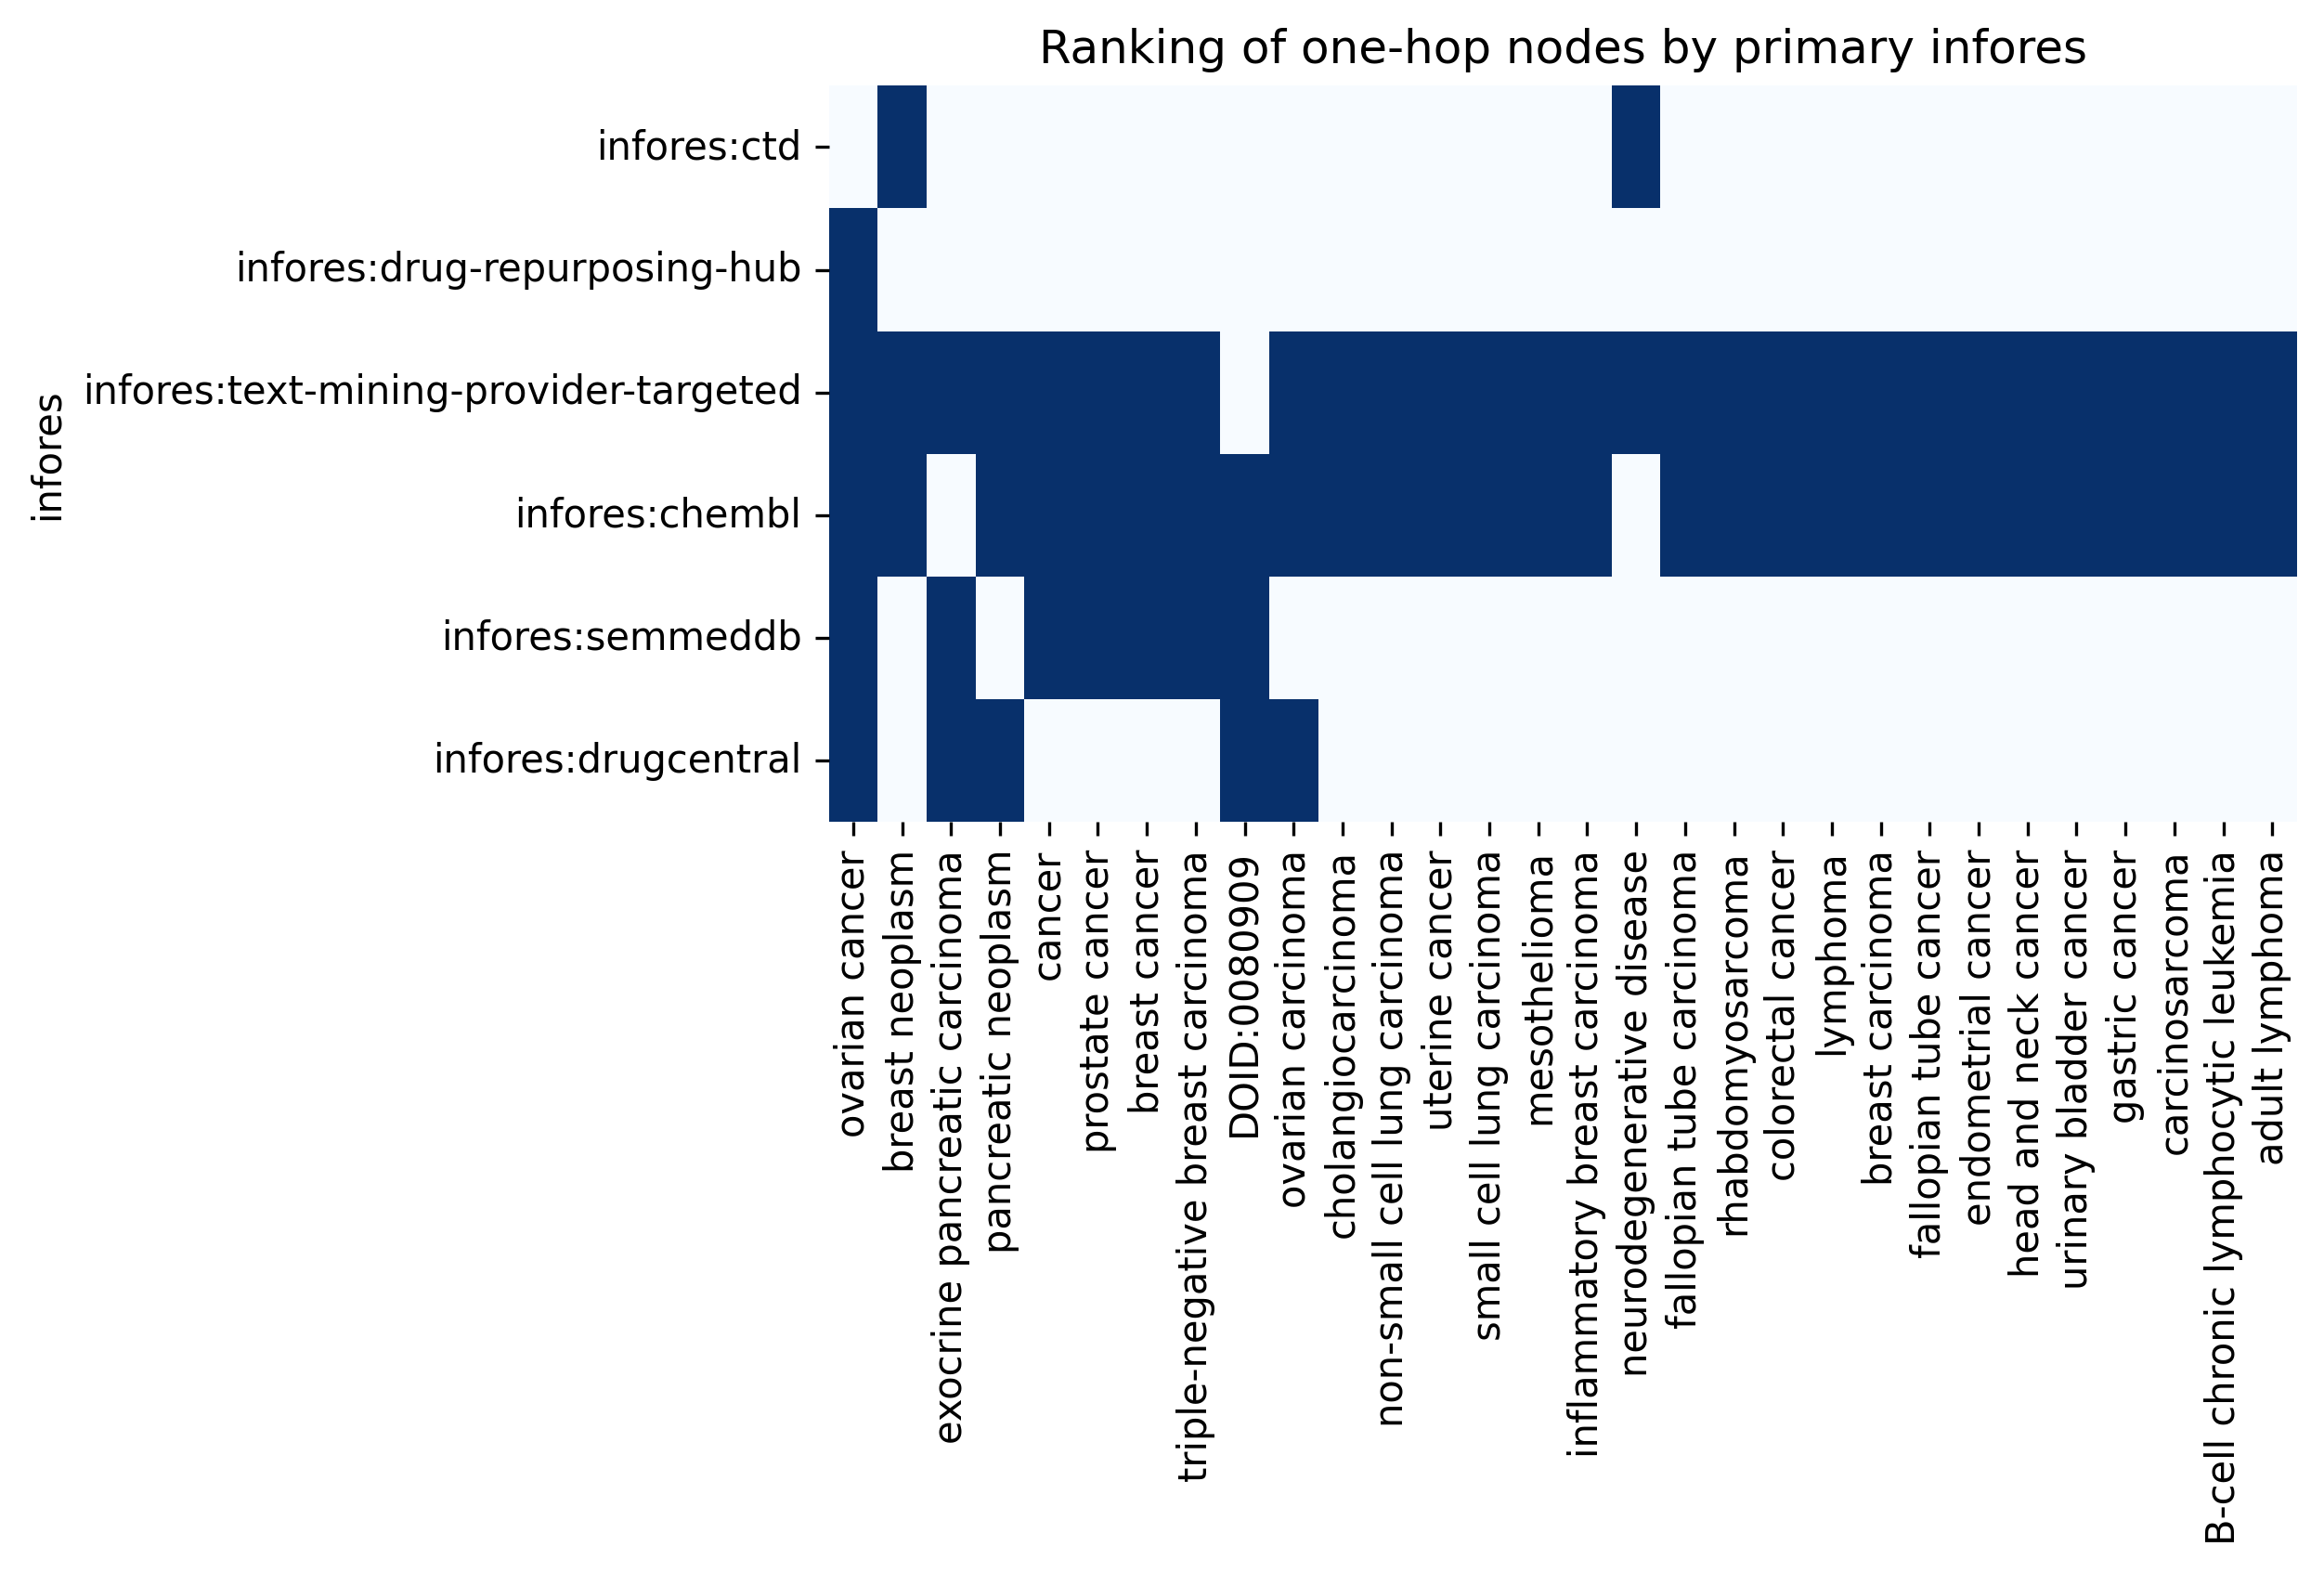

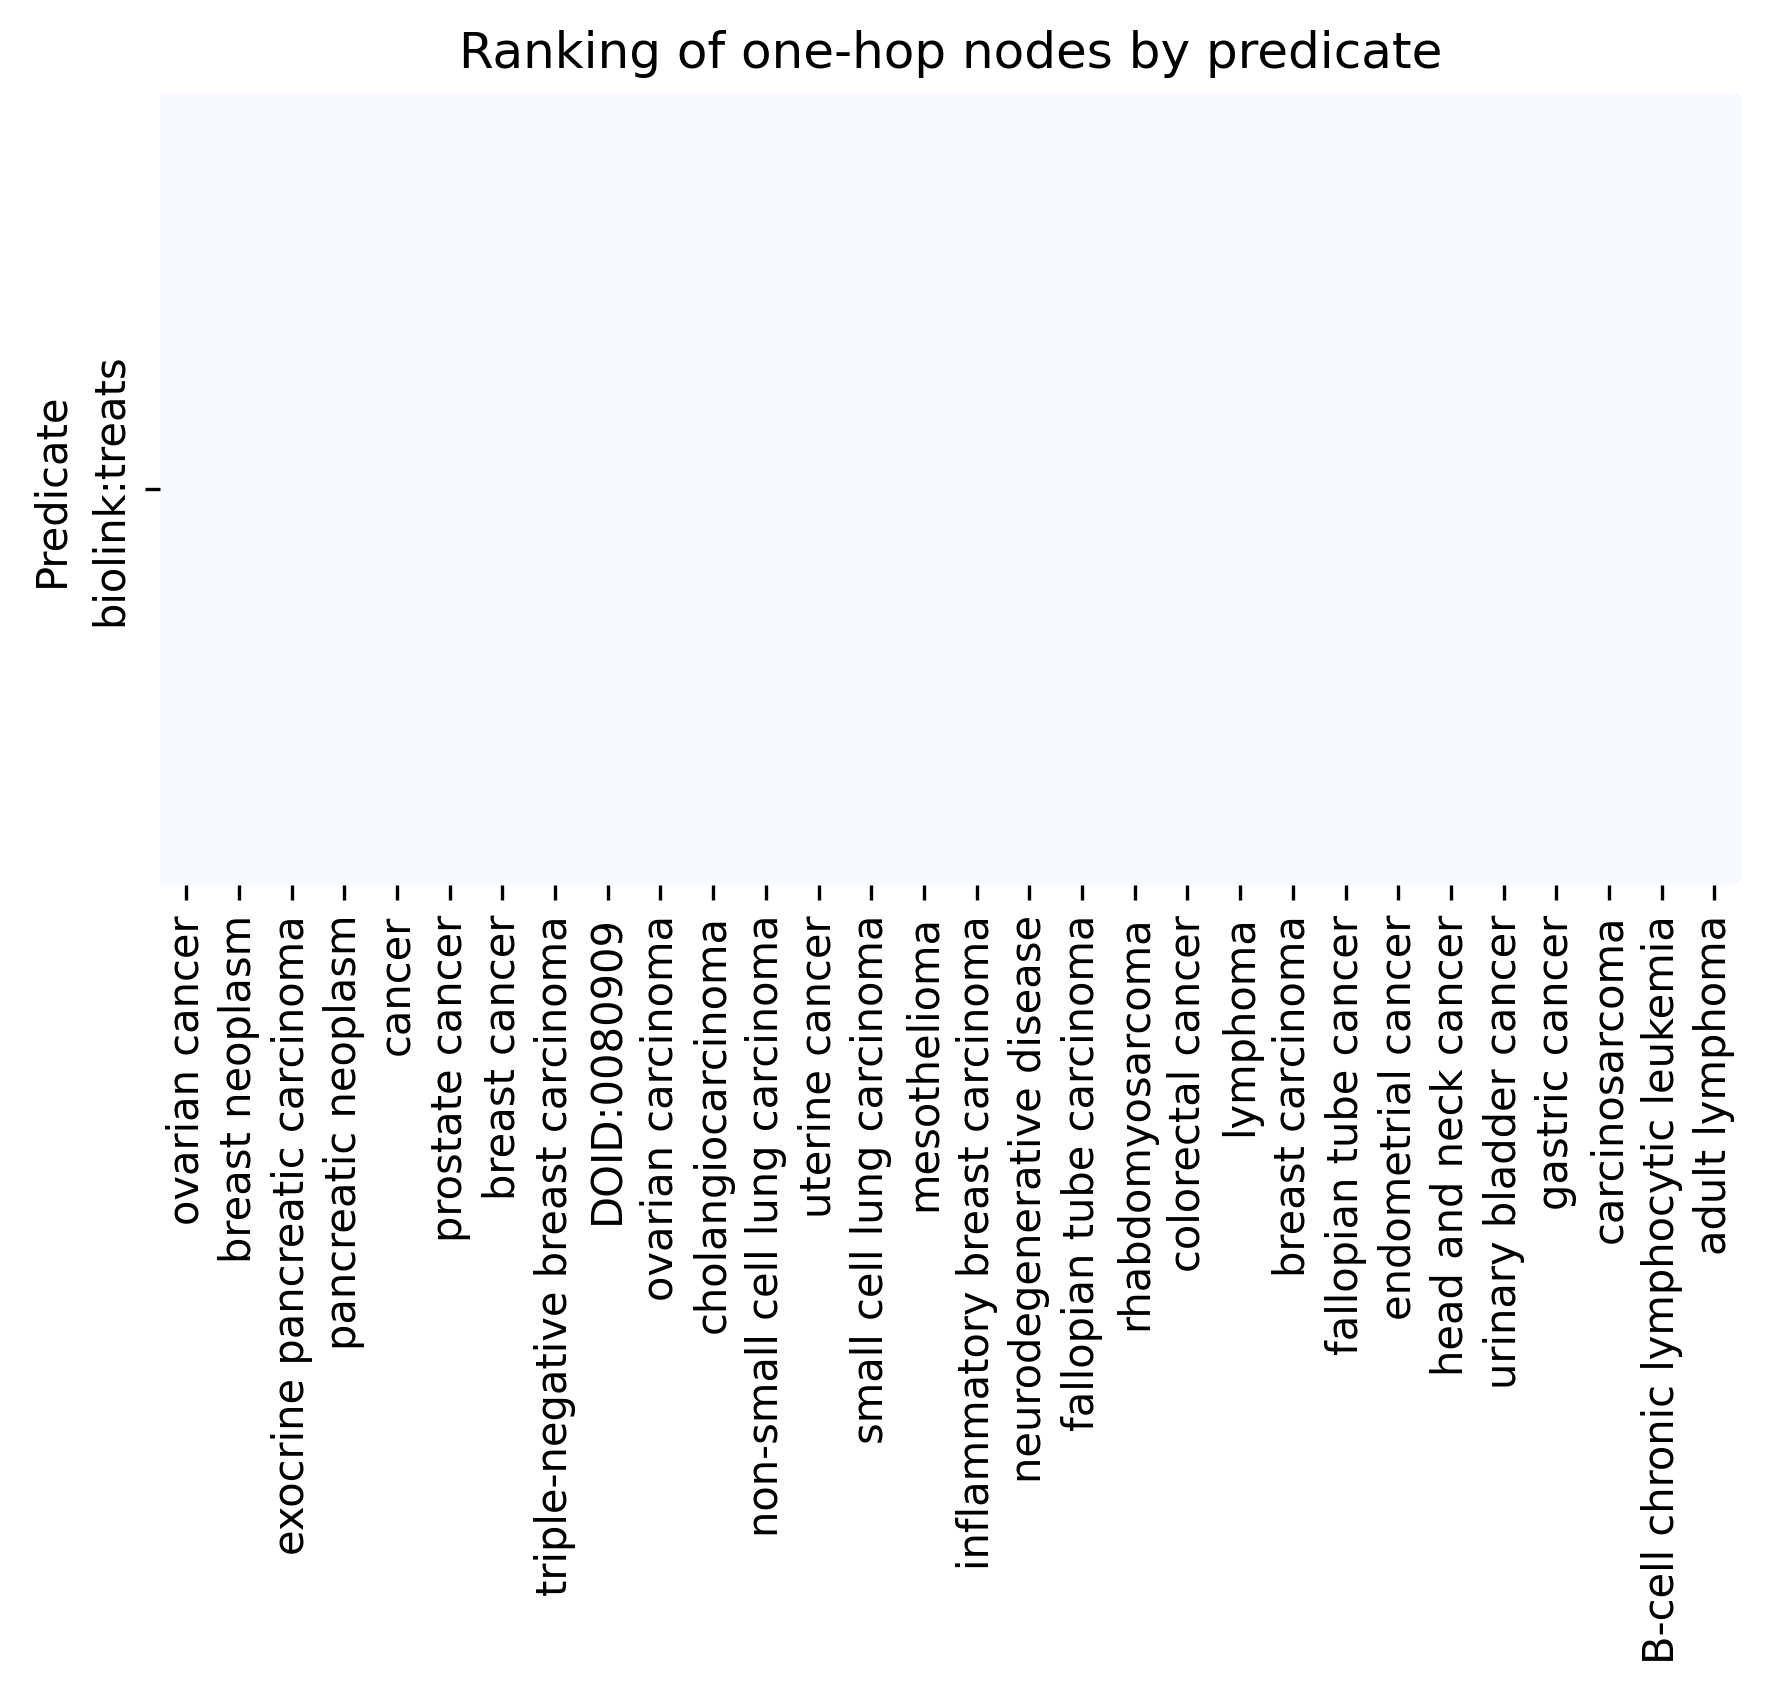

In [60]:
# Step 8: Visualize the results
TCT.visulization_one_hop_ranking(result_ranked_by_primary_infores, result_parsed, 
                                num_of_nodes = 30, input_query = input_node1_id, 
                                fontsize = 10)